# Parameter Inference

### Import Modules

In [2]:
# extern modules
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# intern modules
from PNN_model_2d import ParameterizedNeuralNet

## 1) Load the Model

The sigmoid function saturates for very big and very small values to 1 and 0, respectively and therefore causes _Division by zero_-problems when inverting the function.
Therefore, the ParameterizedNeuralNetwork model is cut at the output layer and now displays the output of the last neuron which is the likelihood ratio.

In [3]:
# path to file
PATH: str = "../trained_models/PNN_2d.pth"

# load model from 
model = ParameterizedNeuralNet(llr_analysis=True)
PNN_state_dict = torch.load(PATH)
model.load_state_dict(PNN_state_dict)

<All keys matched successfully>

## 2) Parameter Inference

The output of the model without the sigmoid is the log likelihood ratio.

In [4]:
# size of true signal
size_true = 100

# parameter mean that should be infered on
true_signal = np.array([0.60, 0.60])

# list for nllr (negative log likelihood ratio)
nllr = []

# x_0 values sampled from a gaussian
x_0 = np.random.multivariate_normal(true_signal, [[0.02, 0],[0, 0.02]], size=size_true)

# range for scanning through NN
signal_range = np.linspace(0, 1, 100)
signals = np.array([[x, y] for x in signal_range for y in signal_range])

# specific background
bg_mean = np.array([0.6, 0.0])
background = np.multiply(np.ones_like(x_0), bg_mean)


# iterating through the NN
for signal_idx, signal in enumerate(signals):

    # generating background and hypothesis
    hypothesis = np.ones_like(x_0) * signal # iterate through the signals for the same x_0 -> result in a parabel of the nllr

    # creation data vector for the PNN
    data = np.empty((size_true, 6))
    data[:, 0:2] = x_0
    data[:, 2:4] = background
    data[:, 4:6] = hypothesis

    # pushing to tensor format
    data_tensor = torch.tensor(data).float()

    # model evaluation
    res = model(data_tensor).detach().numpy()

    # nllr appending
    lr = -2 * np.sum(res)
    nllr.append(lr)

Find inferenced parameter by minimizing the negative loglikelihood function.

In [5]:
# size of nllr
nllr = np.array(nllr)
print(f"Size of nllr: {nllr.shape}.")

# size of signals
print(f"Size of signals: {signals.shape}.")

# min and max values of nllr
val, idx = min((val, idx) for (idx, val) in enumerate(nllr))
print(f"The minimum value of the nll is {np.round(val,2)} from the coordinate: {np.round(signals[idx],2)} "\
      f"which is close to the true value of {np.round(true_signal,2)}.")

Size of nllr: (10000,).
Size of signals: (10000, 2).
The minimum value of the nll is -1677.13 from the coordinate: [0.59 0.57] which is close to the true value of [0.6 0.6].


Plotting the log likelihood ratio function and the infered parameter which is the minimum.

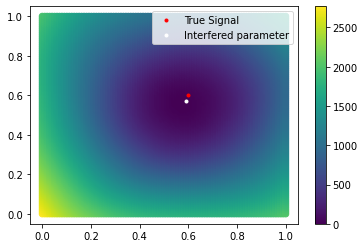

In [6]:
# shift nllr to 0 as minimum
nllr_shift = nllr - nllr.min() 

plt.scatter(signals[:,0], signals[:,1], c=nllr_shift)
plt.plot(true_signal[0], true_signal[1], "r.",label="True Signal")
plt.plot(np.round(signals[idx],2)[0], np.round(signals[idx],2)[1], "w.",label="Interfered parameter")
plt.colorbar()
plt.legend()
plt.show()

In the frequentist approach this is done multiple times to evaluate the mean and variance.

In [7]:
# size of true signal
size_true = 100

# parameter mean that should be infered on
true_signal = np.array([0.60, 0.60])

# range for scanning through NN
signal_range = np.linspace(0, 1, 100)
signals = np.array([[x, y] for x in signal_range for y in signal_range])

# specific background
bg_mean = np.array([0.6, 0.0])
background = np.multiply(np.ones_like(x_0), bg_mean)

# theta data
theta = []

for _ in range(100):
    
    # list for nllr (negative log likelihood ratio)
    nllr = []

    # x_0 values sampled from a gaussian
    x_0 = np.random.multivariate_normal(true_signal, [[0.02, 0],[0, 0.02]], size=size_true)
    # iterating through the NN
    for signal_idx, signal in enumerate(signals):

        # generating background and hypothesis
        hypothesis = np.ones_like(x_0) * signal # iterate through the signals for the same x_0 -> result in a parabel of the nllr

        # creation data vector for the PNN
        data = np.empty((size_true, 6))
        data[:, 0:2] = x_0
        data[:, 2:4] = background
        data[:, 4:6] = hypothesis

        # pushing to tensor format
        data_tensor = torch.tensor(data).float()

        # model evaluation
        res = model(data_tensor).detach().numpy()

        # nllr appending
        lr = -2 * np.sum(res)
        nllr.append(lr)

    # find minimum
    val, idx = min((val, idx) for (idx, val) in enumerate(nllr))
    theta.append(signals[idx])

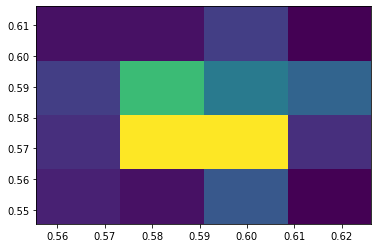

The estimated location in the 5 sigma limit is [0.591 0.578] +- [0.079 0.069]


In [8]:
theta_arr = np.array(theta)
plt.hist2d(theta_arr[:, 0], theta_arr[:, 1], bins=[4,4])
plt.show()

print(f"The estimated location in the 5 sigma limit is {np.round(np.mean(theta_arr, axis=0),3)} +- {np.round(5 * np.std(theta_arr, axis=0), 3)}")

## 3) Confidence intervals 
In the limit we assumed a gaussian distribution around the real value.

0.016


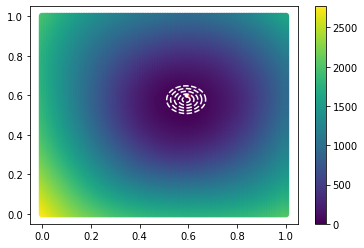

In [21]:
conf_range = np.linspace(0, 2 * np.pi, 100)

theta_x, theta_y = np.round(np.mean(theta_arr, axis=0), 3)
sigma_x, sigma_y = np.round(np.std(theta_arr, axis=0), 3)
print(sigma_x)


plt.scatter(signals[:,0], signals[:,1], c=nllr_shift)
plt.plot(true_signal[0], true_signal[1], "r.",label="True Signal")
plt.plot(np.round(signals[idx],2)[0], np.round(signals[idx],2)[1], "w.",label="Interfered parameter")

for scaler in range(1, 6):
    ellipse_x, ellipse_y = [theta_x + scaler * sigma_x * np.cos(conf_range),theta_y + scaler * sigma_y * np.sin(conf_range)]
    plt.plot(ellipse_x, ellipse_y, "w--", label=f"{scaler} \Sigma")
plt.colorbar()
plt.show()
